# Dimensionality reduction on trial features

In [90]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from sklearn.metrics import f1_score

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [91]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
cluster_df = pd.read_parquet(data_path+'4_mouse_cluster_coef_lab')

# metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/metadata_13-01-2026')
metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/metadata_01-11-2026')


In [5]:
## Get sequences per trial epoch
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge
merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

In [6]:
mice = design_df.mouse_name.unique()
dob = pd.DataFrame(columns=['mouse_name', 'dob'], index=range(len(mice)))
for s, mouse in enumerate(mice):
    subject_info = one.alyx.rest('subjects', 'read', id=mouse)
    date_of_birth = subject_info.get('birth_date')
    dob['mouse_name'][s] = mouse
    dob['dob'][s] = date_of_birth

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_1887/3358271333.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dob['mouse_name'][s] = mouse
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_1887/3358271333.py:7: Futu

## Get sequences per trial

In [7]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [8]:
session_count = design_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
design_df = design_df.loc[design_df['mouse_name'].isin(multi_sess_mice)]

In [9]:
design_df = design_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

## Separate states per variable (one-hot encoding)

In [10]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
# use_sequences = replace_func(use_sequences)

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

## Average per session

In [256]:
session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = design_df['session'].copy()
session_syllables = session_syllables.groupby('session')[np.arange(0, np.shape(binarized)[1], 1)].mean()

In [257]:
mapping = design_df[['mouse_name', 'session', 'mouse_cluster']].drop_duplicates()

Text(0, 0.5, 'Sessions')

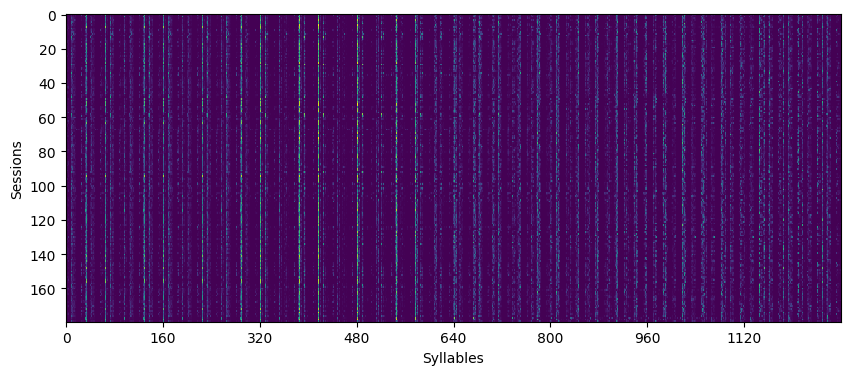

In [258]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.xlabel('Syllables')
plt.ylabel('Sessions')

In [293]:
# final_matrix = np.array(session_syllables)

Text(0.5, 1.0, 'Explained Variance by PCA')

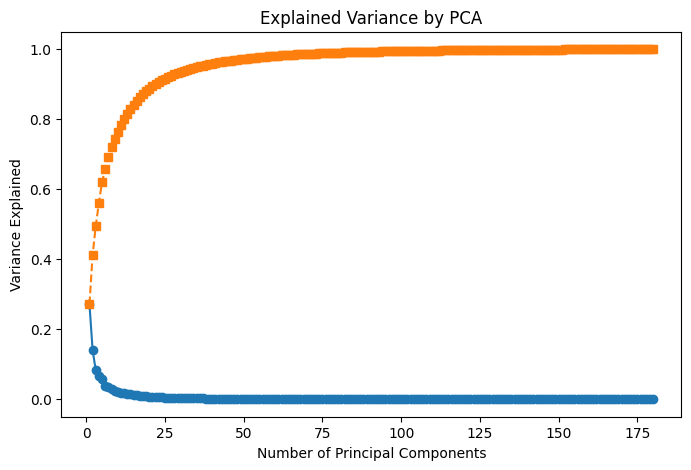

In [259]:
# PCA
n_components = np.shape(np.array(session_syllables))[0]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(np.array(session_syllables))
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(np.array(session_syllables))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [260]:
min_components = np.where(cumulative_variance>0.95)[0][0]

Text(0, 0.5, 'Sessions')

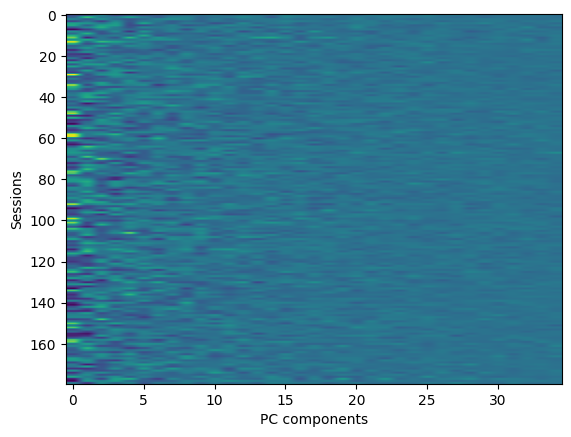

In [261]:
plt.imshow(X_pca[:, :min_components], aspect='auto')
plt.xlabel('PC components')
plt.ylabel('Sessions')

# Normalize per lab

In [262]:
mat = np.array(session_syllables.copy())
mat = np.array(X_pca[:, :min_components])

lab_df = session_syllables.reset_index().merge(metadata, on='session', how='left')
norm_array = np.ones((np.shape(mat))) * np.nan

scaler = StandardScaler()
norm_pop = scaler.fit_transform(mat.copy())
    
labs = np.unique(lab_df['lab'])
labs_array = np.array(lab_df['lab']).copy()
# np.random.shuffle(labs_array)
for i, lab in enumerate(labs):
    lab_idx = np.where(labs_array==lab)[0]
    lab_data = mat[lab_idx, :]

    scaler = StandardScaler()
    scaled = scaler.fit_transform(lab_data.copy())
    norm_array[lab_idx, :] = scaled.copy()

# Normalize per litter

In [81]:
mat = np.array(session_syllables.copy())
mat = np.array(X_pca[:, :min_components])
lab_df = session_syllables.reset_index().merge(metadata, on='session', how='left')
mouse_names = session_syllables.reset_index().merge(mapping, on=['session'])
dob_df = mouse_names.merge(dob, on='mouse_name')

norm_array = np.ones((np.shape(mat))) * np.nan

scaler = StandardScaler()
norm_pop = scaler.fit_transform(mat.copy())
    
litters = np.unique(dob_df['dob'])
litter_array = np.array(dob_df['dob']).copy()
# np.random.shuffle(litter_array)
for i, litter in enumerate(litters):
    litter_idx = np.where(litter_array==litter)[0]
    litter_data = mat[litter_idx, :]

    scaler = StandardScaler()
    scaled = scaler.fit_transform(litter_data.copy())
    norm_array[litter_idx, :] = scaled.copy()

Text(0.5, 1.0, 'Lab normalized')

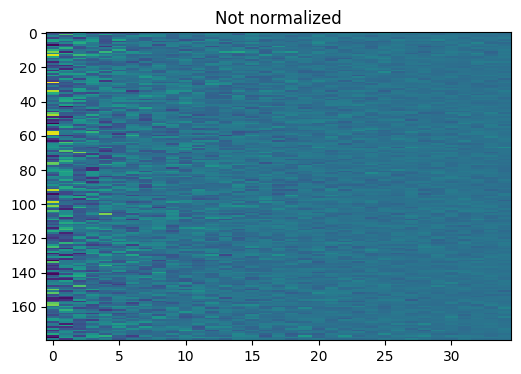

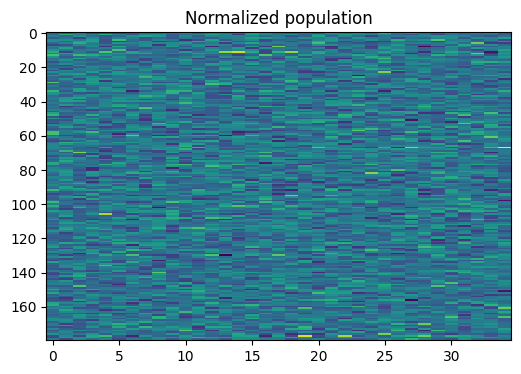

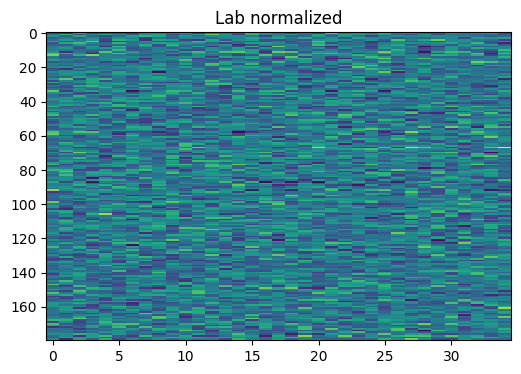

In [252]:
plt.figure(figsize=(6, 4))
plt.imshow(np.array(mat), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Not normalized')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_pop), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Normalized population')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_array), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Lab normalized')

# LDA

In [108]:
n_split = 100

In [109]:
# lda = LinearDiscriminantAnalysis(n_components=50)

mouse_names = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_name']
session_names = session_syllables.reset_index().merge(mapping, on=['session'])['session']
mouse_clusters = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_cluster']
lab_id = session_syllables.reset_index().merge(metadata, on=['session'])['lab']
litter_id = dob_df['dob']
unique_mice = np.unique(mouse_names)

# final_matrix = np.array(norm_pop)
final_matrix = np.array(norm_array)
# final_matrix = np.array(mat)

# scaler = StandardScaler()
# scaled = scaler.fit_transform(final_matrix)
# X = np.array(scaled)

X = final_matrix.copy()
X_train = X[:n_split, :]

y = pd.factorize(mouse_names)[0]
y_train = y[:n_split]

unique_mice = np.unique(y_train)
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', priors=np.ones(len(unique_mice)) / len(unique_mice))
lda = LinearDiscriminantAnalysis(priors=np.ones(len(unique_mice)) / len(unique_mice))
# lda = LinearDiscriminantAnalysis()
X_lda = lda.fit(X_train, y_train).transform(X_train)


In [110]:
X_test = X[n_split:, :]
y_test = y[n_split:]
X_lda_test = lda.transform(X_test)
score = lda.score(X_test, y_test, sample_weight=None)
print(score)


0.475


## Correlation across mouse sessions within training set

In [ ]:
clustered = pd.DataFrame(X_lda)
clustered['mouse_name'] = mouse_names
clustered['lab'] = lab_id
clustered['lab_number'] = pd.factorize(clustered['lab'])[0]
clustered = clustered.merge(cluster_df[['mouse_name', 'mouse_cluster']].drop_duplicates(), on=['mouse_name'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PearsonRResult(statistic=0.9519520360401251, pvalue=1.4437921636134944e-19)


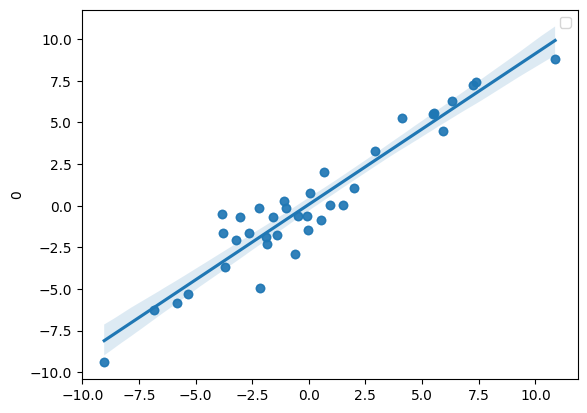

In [69]:
clustered['session'] = clustered.index
minimum = clustered.groupby('mouse_name')['session'].min().reset_index()
maximum = clustered.groupby('mouse_name')['session'].max().reset_index()
session_pairs = minimum.merge(maximum, on='mouse_name')


data1 = clustered.loc[clustered['session'].isin(session_pairs['session_x'])].sort_values(by='mouse_name')
data2 = clustered.loc[clustered['session'].isin(session_pairs['session_y'])].sort_values(by='mouse_name')

use_lda = 0
plt.scatter(data1[use_lda], data2[use_lda], alpha=.6) #, c=data1['mouse_name'])
plt.legend()
# plt.xlim([-5, 5])

sns.regplot(x=np.array(data1[use_lda]).astype(float), y=data2[use_lda].astype(float), ci=95) 
# plt.xticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.yticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.xlabel('True training time (sessions)')
# plt.ylabel('Predicted training time (sessions)')
res = stats.pearsonr(data1[use_lda].astype(float), data2[use_lda].astype(float))
print(res)

## Correlation across mouse sessions in test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PearsonRResult(statistic=0.05187173246356114, pvalue=0.7779847764307684)


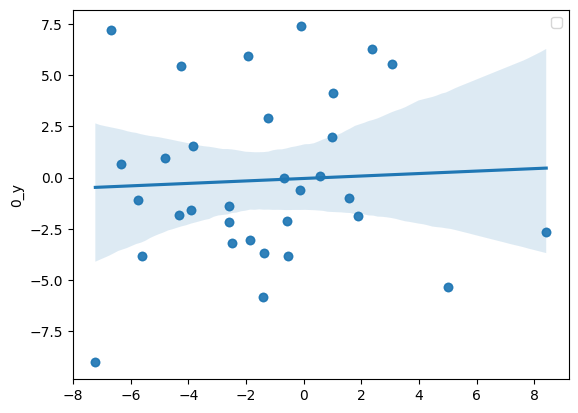

In [73]:
clustered['session'] = clustered.index
minimum = clustered.groupby('mouse_name')['session'].min().reset_index()
maximum = clustered.groupby('mouse_name')['session'].max().reset_index()
session_pairs = minimum.merge(maximum, on='mouse_name')


data1 = clustered.loc[clustered['session'].isin(session_pairs['session_x'])].sort_values(by='mouse_name')
data2 = clustered.loc[clustered['session'].isin(session_pairs['session_y'])].sort_values(by='mouse_name')

datax = pd.DataFrame(X_lda_test)
datax['mouse_name'] = np.array(mouse_names)[n_split:]

common_mice = np.intersect1d(np.array(mouse_names)[n_split:], datax['mouse_name'])
datax = datax.loc[datax['mouse_name'].isin(common_mice)]
datax['session'] = datax.index
ses_x = datax.groupby('mouse_name')['session'].min().reset_index()
datax = datax.loc[datax['session'].isin(ses_x['session'])]
datay = data1.loc[data1['mouse_name'].isin(common_mice)]
joint = datax.merge(datay, on='mouse_name')

use_lda = 0
x_str = str(use_lda)+'_x'
y_str = str(use_lda)+'_y'
plt.scatter(joint[x_str], joint[y_str], alpha=.6) #, c=data1['mouse_name'])
plt.legend()
# plt.xlim([-5, 5])

sns.regplot(x=np.array(joint[x_str]).astype(float), y=joint[y_str].astype(float), ci=95) 
# plt.xticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.yticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.xlabel('True training time (sessions)')
# plt.ylabel('Predicted training time (sessions)')
res = stats.pearsonr(joint[x_str].astype(float), joint[y_str].astype(float))
print(res)

In [35]:
# mat = pd.DatFrame(session_syllables)
mat = session_syllables.merge(mapping[['mouse_name', 'session']], on=['session'])[['mouse_name', 'session']][:100]
mat['lda_1'] = X_lda[:, 0]
mat['lda_2'] = X_lda[:, 1]
mat['lda_3'] = X_lda[:, 2]
mat['lda_4'] = X_lda[:, 3]
mat['lda_5'] = X_lda[:, 4]
mat['lda_6'] = X_lda[:, 5]
mat['lda_7'] = X_lda[:, 6]
mat['lda_8'] = X_lda[:, 7]
mat['lda_9'] = X_lda[:, 8]
mat['lda_10'] = X_lda[:, 9]

mat['mouse_number'] = pd.factorize(mat['mouse_name'])[0]
mat['session_number'] = pd.factorize(mat['session'])[0]


In [36]:
multiple = mat.groupby(['mouse_name'])['session'].count().reset_index()

use_mice = multiple.loc[multiple['session']> 2, 'mouse_name'].unique()
use_mice

array(['CSH_ZAD_019', 'CSH_ZAD_026', 'DY_020', 'NR_0027', 'NYU-30',
       'NYU-45', 'NYU-46', 'PL015', 'PL017', 'PL030', 'PL033', 'PL034',
       'SWC_043', 'SWC_052', 'SWC_053', 'SWC_054', 'UCLA033', 'ZFM-01936',
       'ibl_witten_29'], dtype=object)

## Correlate

In [37]:
merged_df.keys()

Index(['sample', 'trial_type', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'feedback', 'choice', 'block', 'contrast', 'side',
       'session', 'trial_id', 'elongation', 'response', 'reaction',
       'response_qt', 'elongation_qt'],
      dtype='object')

PearsonRResult(statistic=-0.24641742372014247, pvalue=0.013457393783902687)


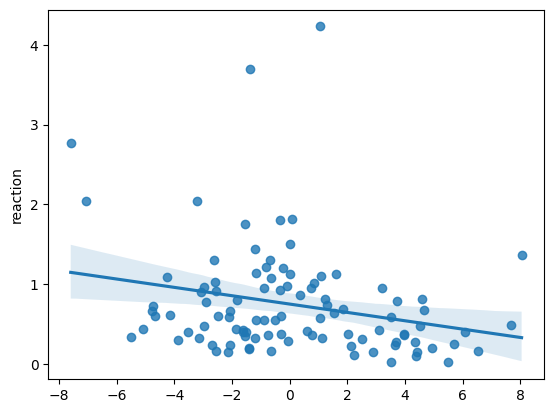

In [53]:
var = 'reaction'
group = merged_df.groupby(['mouse_name', 'session'])[var].mean().reset_index()

merged = group.merge(mat, on=['session'])
# merged = merged.loc[merged['lda_1']>-10]
# merged = merged.loc[merged['lda_1']<25]

use_lda = 'lda_4'

sns.regplot(x=np.array(merged[use_lda]).astype(float), y=merged[var].astype(float), ci=95) 
# plt.xticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.yticks([1.5, 2.5, 3.5, 4.5], np.round(np.exp([1.5, 2.5, 3.5, 4.5])))
# plt.xlabel('True training time (sessions)')
# plt.ylabel('Predicted training time (sessions)')
res = stats.pearsonr(merged[use_lda].astype(float), merged[var].astype(float))
print(res)

## Leave-one-session-out CV

In [263]:
mouse_names = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_name']

In [ ]:
n_per_mouse = 3
rng = np.random.default_rng()

final_matrix = np.array(norm_array)
final_matrix = np.array(norm_array)
X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

n_samples = X.shape[0]
scores = []
lda_components = 20
X_lda_all = np.zeros((n_samples, lda_components))

for test_idx in range(n_samples):

    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)

    X_test = X[test_idx:test_idx+1]
    y_test = y[test_idx:test_idx+1]
    
    X_train_full = X[train_idx]
    y_train_full = y[train_idx]

    # --- balance training set ---
    balanced_idx = []
    for m in np.unique(y_train_full):
        m_idx = np.where(y_train_full == m)[0]
        if len(m_idx) >= n_per_mouse:
            balanced_idx.extend(rng.choice(m_idx, n_per_mouse, replace=False))

    balanced_idx = np.array(balanced_idx)

    X_train = X_train_full[balanced_idx]
    y_train = y_train_full[balanced_idx]

    # --- fit LDA ---
    lda = LinearDiscriminantAnalysis(priors=np.ones(len(np.unique(y_train))) / 
                                     len(np.unique(y_train)), n_components=lda_components)

    lda.fit(X_train, y_train)
    X_lda_all[test_idx] = lda.transform(X_test)[0]
    scores.append(lda.score(X_test, y_test))
print(np.mean(scores))

0.0


In [266]:
np.shape(X_lda_all)

(180, 20)

In [231]:
cluster_df = cluster_df.rename(columns={'cluster':'mouse_cluster'})

In [235]:
# --- fit LDA ---
lda = LinearDiscriminantAnalysis(priors=np.ones(len(np.unique(y_train))) / 
                                    len(np.unique(y_train)), n_components=lda_components)

lda.fit(X_train, y_train)
final_transformed = lda.transform(X_train_full)
clustered = pd.DataFrame(final_transformed)
clustered['mouse_name'] = mouse_names
clustered['lab'] = lab_id
clustered['lab_number'] = pd.factorize(clustered['lab'])[0]
clustered = clustered.merge(cluster_df[['mouse_name', 'mouse_cluster']].drop_duplicates(), on=['mouse_name'])

In [236]:
import plotly.graph_objects as go
from matplotlib import cm

# get tab10 RGBA colors from matplotlib
tab10 = cm.get_cmap('tab10')
colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})' 
          for r, g, b, a in tab10(np.linspace(0, 1, 10))]

fig = go.Figure(
    data=go.Scatter3d(
        x=clustered[0],
        y=clustered[1],
        z=clustered[2],
        mode='markers',
        marker=dict(
            size=5,
            color=[colors[c] for c in clustered['mouse_cluster']]  # assign tab10 color per cluster
        )))

fig.show()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_1887/1589267432.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



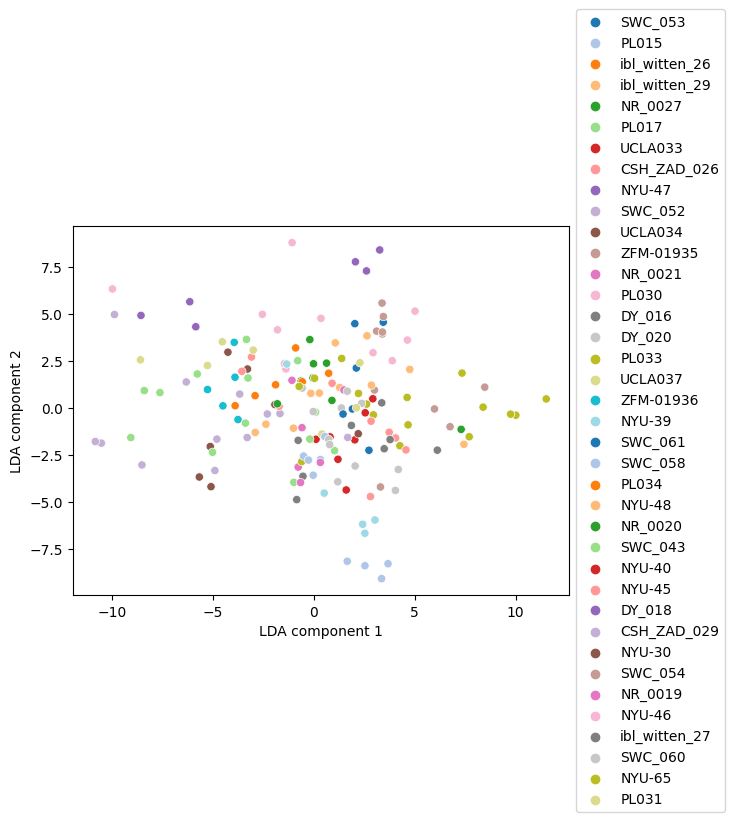

Text(0, 0.5, 'LDA component 2')

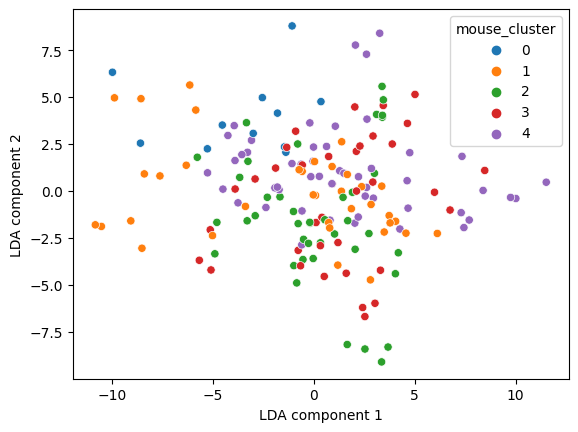

In [237]:
sns.scatterplot(x=0, y=1, hue='mouse_name', data=clustered, palette='tab20')
# plt.legend('')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
sns.scatterplot(x=0, y=1, hue='mouse_cluster', data=clustered, palette='tab10')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
# plt.legend('')
# plt.xlim([-5, 5])
# plt.ylim([-10, 10])

In [267]:
np.sum(lda.explained_variance_ratio_)

0.9710352996773641

Text(0.5, 0, 'LDA components')

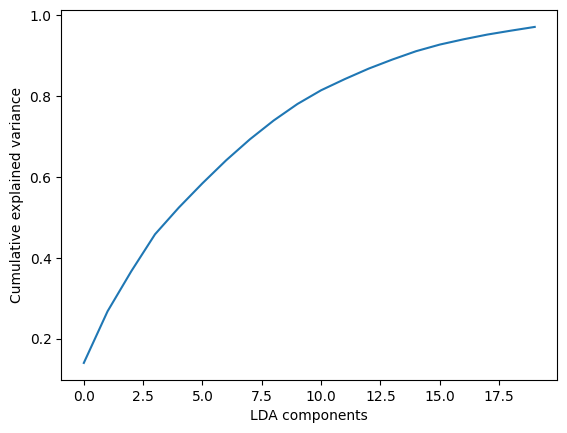

In [268]:
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('LDA components')

## LOMO CV

In [269]:
X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

unique_mice = np.unique(y)
n_features = X.shape[1]

# store predictions only (accuracy)
scores = []

# store LDA loadings per fold (IMPORTANT)
W_folds = []

for test_mouse in unique_mice:

    test_idx = np.where(y == test_mouse)[0]
    train_idx = np.where(y != test_mouse)[0]

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    # # ---- scale INSIDE fold ----
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test  = scaler.transform(X_test)

    # ---- flat priors over TRAINING mice ----
    train_mice = np.unique(y_train)
    priors = np.ones(len(train_mice)) / len(train_mice)

    lda = LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        priors=priors
    )

    lda.fit(X_train, y_train)

    scores.append(lda.score(X_test, y_test))

    # store discriminant directions
    W_folds.append(lda.scalings_[:, :lda.scalings_.shape[1]])

print("LOMO accuracy:", np.mean(scores))


AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'scalings_'